# High school education costs in Sweden
This notebook retrieves and presents data from the API connected to [kolada.se](https://kolada.se/), about high school education costs in Sweden. It currently retrieves data for 3 municipalities.

More information about the API is available at kolada's github repo: https://github.com/Hypergene/kolada
There's some more information here: https://www.kolada.se/om-oss/api/

To find ID's of municipalities, use a query like this: 'http://api.kolada.se/v2/municipality?title=sto', where the title parameter can be used as a search string for municipality (or region) name.

To find relevant key performance indicators (KPI), this is a good starting point: http://api.kolada.se/v2/kpi_groups?title=kkik - that returns subgroups of related key performance indicators.

## Imports

In [1]:
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Function for retrieving and formatting data from url

In [2]:
def kolada_url_to_df(url, value_type_name):
    # get a response object
    resp = requests.get(url)
    # extract JSON data and converts to a Python dictionary
    resp_dict = resp.json()
    # extract 'values', an array of by-period data
    resp_outervalues = resp_dict['values']
    # extract each period's period descriptor, eg '2000'
    resp_period = [x['period'] for x in resp_outervalues]
    # convert into pandas periodindex - assumes that periods are in yearly frequency
    resp_period = pd.PeriodIndex(resp_period, freq="Y")
    # extract each period's measured value
    # each chunk of period data has an inner 'values' chunk, which in turn is a single-element
    # array (so far at least), where the single element in turn has a 'value' key which
    # maps to the *actual* value for the period
    resp_values = [x['values'][0]['value'] for x in resp_outervalues] 
    # convert to pandas dataframe
    df = pd.DataFrame(
        {value_type_name: resp_values}, 
        index=resp_period
    )
    return df

In [3]:
# specify request URL's
kga_hschoolcost_url = 'https://api.kolada.se/v2/data/kpi/N17005/municipality/1883'
karlskrona_hschoolcost_url = 'https://api.kolada.se/v2/data/kpi/N17005/municipality/1080'
sthlm_hschoolcost_url = 'https://api.kolada.se/v2/data/kpi/N17005/municipality/0180'

In [4]:
# make the requests and convert to separate single-column data frames
kga_hscosts = kolada_url_to_df(kga_hschoolcost_url, 'hs_student_yearly_cost')
karlskrona_hscosts = kolada_url_to_df(karlskrona_hschoolcost_url, 'hs_student_yearly_cost')
sthlm_hscosts = kolada_url_to_df(sthlm_hschoolcost_url, 'hs_student_yearly_cost')

In [5]:
# merge the data frames into a single data frame
multi_hscosts = (
    # rename 'per year cost' columns in the separate data frames and then combine
    # the data frames based on index (assumes that data are collected for the same
    # years for all municipalities)
    pd.merge(
        kga_hscosts.rename(columns={'hs_student_yearly_cost': 'karlskoga'}), 
        karlskrona_hscosts.rename(columns={'hs_student_yearly_cost': 'karlskrona'}), 
        left_index=True, right_index=True,
    )
    .merge(
        sthlm_hscosts.rename(columns={'hs_student_yearly_cost': 'stockholm'}),
        left_index=True, right_index=True
    )
    # gather all 'per year cost' data in a single column, using a secondary
    # column which indicates which municipality the data point is related
    # to
    .melt(
        var_name='municipality',
        value_name='hs_student_yearly_cost', 
        ignore_index=False
    )
)

[Text(0, 0, '1998'),
 Text(0, 0, '2000'),
 Text(0, 0, '2002'),
 Text(0, 0, '2004'),
 Text(0, 0, '2006'),
 Text(0, 0, '2008'),
 Text(0, 0, '2010'),
 Text(0, 0, '2012'),
 Text(0, 0, '2014'),
 Text(0, 0, '2016'),
 Text(0, 0, '2018'),
 Text(0, 0, '2020')]

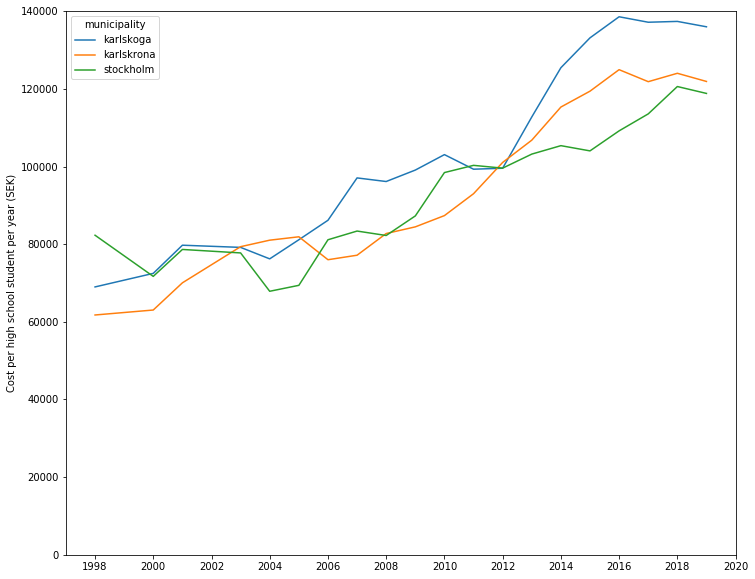

In [6]:
# create the figure and single axis to use first, to enable
# more direct control over axis visuals
fig, ax = plt.subplots(figsize=(12, 10))
# draw a line plot, where data are grouped/colored by municipality
sns.lineplot(
    # convert the PeriodIndex instance to timestamps, since
    # seaborn doesn't seem to know how to use PeriodIndex objects
    x=multi_hscosts.index.to_timestamp(),
    y=multi_hscosts.hs_student_yearly_cost, 
    hue=multi_hscosts.municipality,
    ax=ax
)
ax.set_ylabel('Cost per high school student per year (SEK)')
ax.set_ylim(0, 140000)
ax.set_xlim(
    pd.to_datetime('1997-01-01'),
    pd.to_datetime('2020-01-01')
)
ax.set_xticks([pd.to_datetime(f'{yr}-01-01') for yr in range(1998, 2021, 2)])
ax.set_xticklabels([f'{yr}' for yr in range(1998, 2021, 2)])